In [1]:
from lib.backbone import StackedHGNetV1
from lib.utility import get_dataloader

In [2]:
class Model_Config:
    def __init__(self):
        self.classes_num = [68, 9, 68]
        self.edge_info = (
                (False, (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16)),  # FaceContour
                (False, (17, 18, 19, 20, 21)),  # RightEyebrow
                (False, (22, 23, 24, 25, 26)),  # LeftEyebrow
                (False, (27, 28, 29, 30)),  # NoseLine
                (False, (31, 32, 33, 34, 35)),  # Nose
                (True, (36, 37, 38, 39, 40, 41)),  # RightEye
                (True, (42, 43, 44, 45, 46, 47)),  # LeftEye
                (True, (48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59)),  # OuterLip
                (True, (60, 61, 62, 63, 64, 65, 66, 67)),  # InnerLip
            )
        self.nstack = 4
        self.add_coord = True
        self.decoder_type = "default"
        self.width = 256
        self.height = 256
        self.use_AAM = True

In [3]:
model_config = Model_Config()
net = StackedHGNetV1(config=model_config,
                        classes_num=model_config.classes_num,
                        edge_info=model_config.edge_info,
                        nstack=model_config.nstack,
                        add_coord=model_config.add_coord,
                        decoder_type=model_config.decoder_type)

In [4]:
net

StackedHGNetV1(
  (pre): Sequential(
    (0): CoordConvTh(
      (addcoords): AddCoordsTh()
      (conv): Conv2d(6, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
      (relu): ReLU()
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ResBlock(
      (relu): ReLU()
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): ConvBlock(
        (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      )
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): ConvBlock(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): ConvBlock(
        (conv): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
      )
      (skip_layer): ConvBlock(
        (conv): Conv2d(64, 128, kernel_size

In [5]:
class Data_Config:
    def __init__(self):
            self.train_tsv_file = 'pub_annot/300W/train.tsv'
            self.val_tsv_file = 'pub_annot/300W/test.tsv'
            self.train_pic_dir = 'pub_dataset/300W'
            self.val_pic_dir = 'pub_dataset/300W'
            self.loader_type = 'alignment'
            self.batch_size = 16
            self.val_batch_size = 32
            self.train_num_workers = 1
            self.val_num_workers = 1
            self.width = 256
            self.height = 256
            self.channels = 3
            self.means = (127.5, 127.5, 127.5)
            self.scale = 0.00784313725490196
            self.classes_num = [68, 9, 68]
            self.crop_op = True
            self.aug_prob = 1.0
            self.edge_info = (
                (False, (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16)),  # FaceContour
                (False, (17, 18, 19, 20, 21)),  # RightEyebrow
                (False, (22, 23, 24, 25, 26)),  # LeftEyebrow
                (False, (27, 28, 29, 30)),  # NoseLine
                (False, (31, 32, 33, 34, 35)),  # Nose
                (True, (36, 37, 38, 39, 40, 41)),  # RightEye
                (True, (42, 43, 44, 45, 46, 47)),  # LeftEye
                (True, (48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59)),  # OuterLip
                (True, (60, 61, 62, 63, 64, 65, 66, 67)),  # InnerLip
            )
            self.flip_mapping = ([0, 16], [1, 15], [2, 14], [3, 13], [4, 12], [5, 11], [6, 10], [7, 9], [17, 26], [18, 25], [19, 24], [20, 23], [21, 22], [31, 35], [32, 34], [36, 45], [37, 44], [38, 43], [39, 42], [40, 47], [41, 46], [48, 54], [49, 53], [50, 52], [61, 63], [60, 64], [67, 65], [58, 56], [59, 55])
            self.encoder_type = 'default'

In [6]:
data_config = Data_Config()
train_loader = get_dataloader(data_config, data_type='train', world_rank=0, world_size=1)
val_loader = get_dataloader(data_config, "val")

In [7]:
import numpy as np
import pandas as pd
import cv2
import re
import matplotlib.pyplot as plt
import torch

300W Original Label

In [8]:
train_label = pd.read_csv(data_config.train_tsv_file, sep="\t", header=None)

In [9]:
line = train_label[train_label.iloc[:,0].apply(lambda x: re.search(r'2838782176_1\.jpg',x)!=None)].iloc[0]

In [10]:
def get_label(line):
    image_path = line[0]
    landmarks_5pts = line[1]
    landmarks_5pts = np.array(list(map(float, landmarks_5pts.split(","))), dtype=np.float32).reshape(5, 2)
    landmarks_target = line[2]
    landmarks_target = np.array(list(map(float, landmarks_target.split(","))), dtype=np.float32).reshape(
        data_config.classes_num[0], 2)
    scale = float(line[3])
    center_w, center_h = float(line[4]), float(line[5])
    return image_path,landmarks_5pts,landmarks_target,scale,center_w,center_h

In [11]:
image_path,landmarks_5pts,landmarks_target,scale,center_w,center_h = get_label(line)

In [12]:
img = cv2.imread(image_path.replace('rawImages','pub_dataset/300W'), cv2.IMREAD_COLOR)

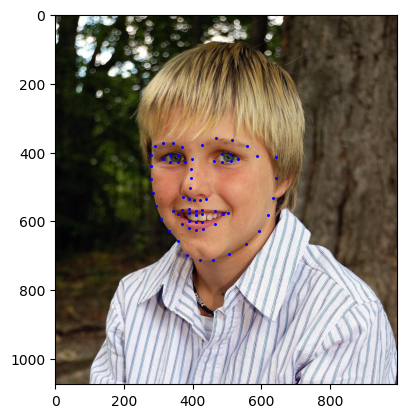

In [13]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.scatter(landmarks_target[:,0], landmarks_target[:,1], s=5, marker='.', c='b')

Processed Data

In [14]:
def denorm_points(points, h, w, align_corners=False):
    if align_corners:
        # [-1, +1] -> [0, SIZE-1]
        des_points = (points + 1) / 2 * torch.tensor([w - 1, h - 1]).to(points).view(1, 1, 2)
    else:
        # [-1, +1] -> [-0.5, SIZE-0.5]
        des_points = ((points + 1) * torch.tensor([w, h]).to(points).view(1, 1, 2) - 1) / 2
    return des_points

In [15]:
for batch,sample in enumerate(train_loader):
    break

In [16]:
i = 2
print(sample['data'][i].numpy().shape)
img = sample['data'][i]
len(sample['label']) # landmarks, heatmap, edgemap
landmarks, heatmaps, edgemaps = sample['label']
landmark = landmarks[i]
heatmap = heatmaps[i]
edgemap = edgemaps[i]
matrixs = sample['matrix']
matrix = matrixs[i]

(3, 256, 256)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


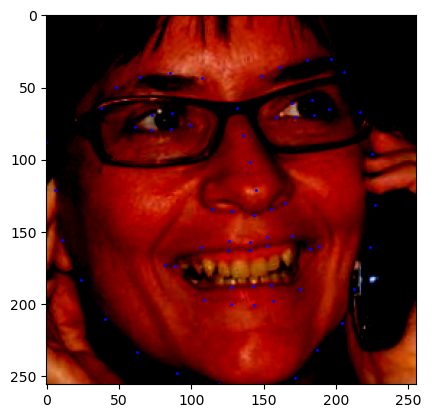

In [17]:
denorm_landmark = denorm_points(landmark,h=256,w=256).squeeze()
ori_img = cv2.cvtColor(img.numpy().transpose(1, 2, 0), cv2.COLOR_BGR2RGB) #'pub_dataset/300W/helen/trainset/2838782176_1.jpg'
plt.imshow(ori_img)
plt.scatter(denorm_landmark[:,0], denorm_landmark[:,1], s=5, marker='.', c='b')

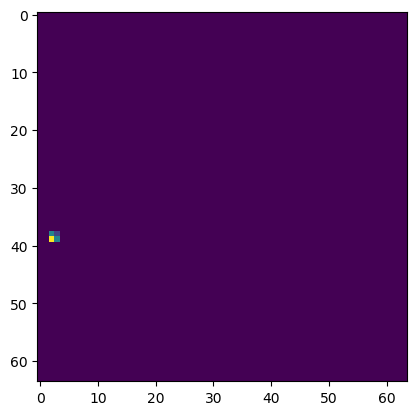

In [18]:
plt.imshow(heatmap[2], cmap='viridis', interpolation='nearest')

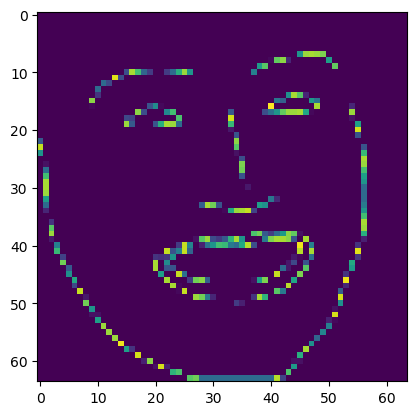

In [19]:
combined_edgemap = np.max(edgemap.numpy(), axis=0)
plt.imshow(combined_edgemap, cmap='viridis', interpolation='nearest')

In [113]:
output, heatmaps, landmarks = net(sample['data'])
# output: [landmarks, pointmaps, edgemaps ] * nstack


In [111]:
img.shape

torch.Size([3, 256, 256])